# USEFUL NOTES


*   At heading <font color='magenta'>"LOAD THE FILES"</font>, change the name of the variable <font color='magenta'>*file_to_be_tested*</font>
*   Execute all cells in the given order (if there is no different direction)
*   <font color='cyan'>All the metrics</font> concern the <font color='cyan'>VALIDATION SET</font>

*   If you want to execute the cells with the various experiments, please follow the instructions provided below (at each heading) on how to do it.

# LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from IPython.display import Math, HTML
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-12-23 18:40:32--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-23 18:40:32--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.04MB/s    in 2m 40s  

2021-12-23 18:43:13 (5.14 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: 

# CONNECTION WITH GOOGLE DRIVE TO GET THE FILES

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd drive/MyDrive

/content/drive/MyDrive


In [5]:
import os
path = os.getcwd()
path

'/content/drive/MyDrive'

# <font color='pink'>LOAD THE FILES</font>

In [6]:
#should be in the same directory with the colab notebook
file_to_be_loaded = "vaccine_train_set.csv"
file_to_be_tested = "vaccine_validation_set.csv"     #replace with the test_set.csv

In [7]:
training_df = pd.read_csv(file_to_be_loaded)
validation_df = pd.read_csv(file_to_be_tested)
training_df['cleaned tweet'] = training_df['tweet']
validation_df['cleaned tweet'] = validation_df['tweet']

In [8]:
import os
path = os.getcwd()
os.chdir('/content')
path = os.getcwd()


# <font color='pink'>PRE-PROCESS THE DATA</font>

In [9]:
def clean(df):
  to_be_removed = ['@', '@ ', 'http']
  stop_words = stopwords.words('english') 
  tokenizer = nltk.RegexpTokenizer(r"\w+")

  for row in range(len(df)):
    words_to_be_removed = set()
    r = df['cleaned tweet'].values[row].split('\n')
    r = ' '.join(r)
    r = r.split(',')
    r = ' '.join(r)
    r = r.split('.')
    r = ' '.join(r)
    r = r.split()
    r = [w.lower() for w in r]
    for word in r:
      word = word.lower()
      for item in to_be_removed:   #word has @, http
        if item in word:
          words_to_be_removed.add(word)
          break
      # for w in stop_words:  #word is and, a, an, the etc
      #   if w == word:
      #     words_to_be_removed.add(word)
      #     break
    for word in list(words_to_be_removed):  #remove them from the data
      r = list(filter(lambda x: x != word, r)) 
    df.iloc[row, 3] = ' '.join(r)

    # words_to_be_removed = set()
    # r = tokenizer.tokenize(df.iloc[row, 1])   #remove all tokens
    # df.iloc[row, 1] = ' '.join(r)
    # r = df.iloc[row, 1].split()
    for word in r: 
      if word.isdigit():   #remove the numbers
        words_to_be_removed.add(word)
    for word in list(words_to_be_removed):
      r = list(filter(lambda x: x != word, r))
    df.iloc[row, 3] = ' '.join(r)
    #print(r)
  return df

In [10]:
def Preprocess_Data(data_set, cleaning=clean):

  if cleaning:
    data_set = clean(data_set)
  return data_set


In [11]:
Preprocess_Data(training_df)
Preprocess_Data(validation_df)
training_df.head(5)

,Unnamed: 0,tweet,label,cleaned tweet
0,0,Sip N Shop Come thru right now #Marjais #Popul...,0,sip n shop come thru right now #marjais #popul...
1,1,I don't know about you but My family and I wil...,1,i don't know about you but my family and i wil...
2,2,@MSignorile Immunizations should be mandatory....,2,immunizations should be mandatory period in ok...
3,3,President Obama spoke in favor of vaccination ...,0,president obama spoke in favor of vaccination ...
4,4,"""@myfoxla: Arizona monitoring hundreds for mea...",0,arizona monitoring hundreds for measles linked...


# <font color='cyan'>Functions for METRICS</font>

In [12]:
def Learning_Curve(n_epochs, train_loss, valid_loss):  #create the learning curve
  plt.plot(n_epochs, train_loss, 'm')
  plt.plot(n_epochs, valid_loss, 'c')
  plt.title("Learning Curve")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(["training", "validation"], loc ="upper right")
  plt.show()
  return

In [13]:
def ROC_Curve(y_true, y_pred):
  fp = {}
  tp = {}
  thresh ={}

  classes = 3

  for i in range(classes):    
      fp[i], tp[i], thresh[i] = roc_curve(y_true.detach().numpy(), y_pred[:,i].detach().numpy(), pos_label=i)
      
  # plotting    
  plt.plot(fp[0], tp[0], color='m', label='Class 0 vs Rest')
  plt.plot(fp[1], tp[1], color='c', label='Class 1 vs Rest')
  plt.plot(fp[2], tp[2], color='b', label='Class 2 vs Rest')
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc='lower right')
  plt.show()
  return

In [14]:
def calculate_metrics(y_true, y_pred, y_pred_class):

  y_true1 = y_true.view(y_true.shape[0])
  y_valid_class = y_true1.tolist()
  classes = ['class 0', 'class 1', 'class 2']
  print(classification_report(y_valid_class, y_pred_class, target_names=classes, zero_division = 0))
  print("Precision score:\t", precision_score(y_true,y_pred.argmax(1), average = 'macro'))
  print("Recall score:\t\t", recall_score(y_true,y_pred.argmax(1), average = 'macro'))
  print("F1 score:\t\t", f1_score(y_true,y_pred.argmax(1), average = 'macro'))
  return

# <font color='cyan'>Targets, Feautures and Initialize Dataloader</font>

In [15]:
def Initialize_feauture_Targets(size):

  #Separate features and targets
  x_training_df = pd.DataFrame(training_numeric_array)  
  y_training_df = pd.DataFrame(training_df['label'])

  x_validation_df = pd.DataFrame(validation_numeric_array)
  y_validation_df = pd.DataFrame(validation_df['label'])

  #Save in tensors
  x_train = torch.tensor(x_training_df.values, dtype=torch.float)
  y_train = torch.tensor(y_training_df.values)

  x_valid = torch.tensor(x_validation_df.values, dtype=torch.float)
  y_valid = torch.tensor(y_validation_df.values)

  #Initialize dataloader
  train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
  train_dataloader = DataLoader(train_dataset, batch_size=size, shuffle=True)


  return x_train, y_train, x_valid, y_valid, train_dataset, train_dataloader

# <font color='greenyellow'>Neural Network using Glove</font>

## <font color='pink'>GLOVE WORD EMBEDDINGS</font>

In [16]:
file1 = 'glove.6B.50d.txt'
file2 = 'glove.6B.100d.txt'
file3 = 'glove.6B.200d.txt'
file4 = 'glove.6B.300d.txt'

In [17]:
embedding_dict = {}
result = []

with open(file3, encoding='utf-8') as f:
  i = 0
  for line in f:
    line = line.split()
    word = line[0]
    arr = np.array((line[1:])).astype(np.float)
    result.append(arr)
    embedding_dict[word] = i
    i += 1
A = np.asarray(result)   #array with the pretrained vector of every word in the glove.txt file

arr_dimensions = A.shape
embedding_dimension = arr_dimensions[1]  #how many features each word has - the dimension of the respective glove.txt file


In [18]:
def Sentence_Representation_with_Embeddings(df, embedding_dict, glove_array, embedding_dimension):
  sentence_dict = {}
  result = []
  for row in range(len(df)):
    words_to_be_removed = set()
    sentence = df['cleaned tweet'].values[row].split()
    sentence_array = []
    for word in sentence:
      if word in embedding_dict.keys():
        value = glove_array[embedding_dict[word], :]
        sentence_array.append(value)
      else:
        value = np.random.rand(glove_array.shape[1]).astype(np.float)
        sentence_array.append(value)
        
    sentence_array = np.asarray(sentence_array).astype(np.float)
    sentence_array = np.transpose(sentence_array)
    sentence_array = np.average(sentence_array, axis=1)
    sentence_array = np.reshape(sentence_array, (1, embedding_dimension))
    result.append(sentence_array)


  result = np.asarray(result).astype(np.float)
  result = np.reshape(result, (df.shape[0], embedding_dimension))
  return result

In [19]:
training_numeric_array = Sentence_Representation_with_Embeddings(training_df, embedding_dict, A, embedding_dimension)
training_numeric_array.shape

(15976, 200)

In [20]:
validation_numeric_array = Sentence_Representation_with_Embeddings(validation_df, embedding_dict, A, embedding_dimension)
validation_numeric_array.shape

(2282, 200)

## <font color='magenta'>Training and Evaluation using MSELoss</font>

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
      
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H2, D_out)
        
    def forward(self, x):
        h1 = self.linear1(x)
        # h1 = self.activation(h1)
        h2 = self.linear2(h1)
        # h2 = self.activation(h2)
        h3 = self.linear3(h2)
        # h3 = self.activation(h3)
        out = self.linear4(h2)
        return out

In [22]:
x_train, y_train, x_valid, y_valid, train_dataset, train_dataloader = Initialize_feauture_Targets(100)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

torch.Size([15976, 200]) torch.Size([15976, 1])
torch.Size([2282, 200]) torch.Size([2282, 1])


In [23]:
#Define layer sizes
D_in = embedding_dimension
H1 = 45
H2 = 20
H3 = 8
D_out = 3

#Define Hyperparameters
learning_rate = 1e-4

#Initialize model, loss, optimizer
Glove_Model = NeuralNetwork(D_in, H1, H2, H3, D_out)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(Glove_Model.parameters(), lr=learning_rate)

In [24]:
#loss_func = MSELoss()
def Train_and_Evaluate_Neural_Network_MSE(Glove_Model, train_dataloader, x_valid):
  train_epoch_losses = []
  valid_epoch_losses = []

  for epoch in range(100):
    train_batch_losses = []
    Glove_Model.train()
    for x_train_batch, y_train_batch in train_dataloader:
      y_train_pred = Glove_Model(x_train_batch)
      train_prob = nn.Softmax(dim=1)(y_train_pred)
      y_train_pred_class = torch.argmax(train_prob, dim=1)
      
      y_train_batch_one_hot = torch.nn.functional.one_hot(y_train_batch)
      y_train_batch_one_hot = y_train_batch_one_hot.reshape(y_train_pred.shape[0], y_train_pred.shape[1])
      loss = loss_func(y_train_pred.float(), y_train_batch_one_hot.float())
      train_batch_losses.append(loss.item())

      #Delete previously stored gradients
      optimizer.zero_grad()
      #Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()
      #Update model's weights based on the gradients calculated during backprop
      optimizer.step()
      train_epoch_loss = sum(train_batch_losses) / len(train_dataloader)
      
    if (epoch % 9 == 0):
      print(f"Epoch {epoch:3}: Train Loss = {train_epoch_loss:.5f}")
    train_epoch_losses.append(train_epoch_loss)


    Glove_Model.eval()
    # optimizer.zero_grad()
    y_valid_pred = Glove_Model(x_valid)
    valid_prob = nn.Softmax(dim=1)(y_valid_pred)
    y_valid_pred_class = torch.argmax(y_valid_pred, dim=1)

    y_valid_one_hot = torch.nn.functional.one_hot(y_valid)
    y_valid_one_hot = y_valid_one_hot.reshape(y_valid_pred.shape[0], y_valid_pred.shape[1])
    loss = loss_func(y_valid_pred.float(), y_valid_one_hot.float())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    valid_epoch_losses.append(loss.item())
    if (epoch % 9 == 0):
      print(f"Epoch {epoch:3}: Validation Loss = {loss:.5f}")

  return train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_pred
      

In [25]:
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_pred = Train_and_Evaluate_Neural_Network_MSE(Glove_Model, train_dataloader, x_valid = x_valid)

Epoch   0: Train Loss = 0.25672
Epoch   0: Validation Loss = 0.19723
Epoch   9: Train Loss = 0.16757
Epoch   9: Validation Loss = 0.17032
Epoch  18: Train Loss = 0.16349
Epoch  18: Validation Loss = 0.16698
Epoch  27: Train Loss = 0.16198
Epoch  27: Validation Loss = 0.16579
Epoch  36: Train Loss = 0.16114
Epoch  36: Validation Loss = 0.16559
Epoch  45: Train Loss = 0.16062
Epoch  45: Validation Loss = 0.16511
Epoch  54: Train Loss = 0.16029
Epoch  54: Validation Loss = 0.16579
Epoch  63: Train Loss = 0.16001
Epoch  63: Validation Loss = 0.16495
Epoch  72: Train Loss = 0.15982
Epoch  72: Validation Loss = 0.16485
Epoch  81: Train Loss = 0.15981
Epoch  81: Validation Loss = 0.16468
Epoch  90: Train Loss = 0.15981
Epoch  90: Validation Loss = 0.16489
Epoch  99: Train Loss = 0.15971
Epoch  99: Validation Loss = 0.16466


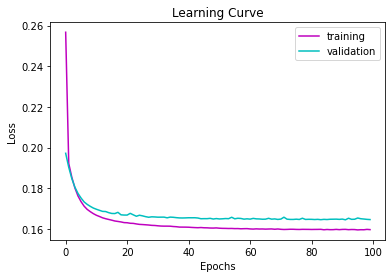

In [26]:
epochs = np.arange(0, 100).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [27]:
calculate_metrics(y_valid, y_valid_pred, y_valid_pred_class)

              precision    recall  f1-score   support

     class 0       0.65      0.77      0.71      1065
     class 1       0.60      0.04      0.08       296
     class 2       0.59      0.64      0.61       921

    accuracy                           0.62      2282
   macro avg       0.61      0.48      0.47      2282
weighted avg       0.62      0.62      0.59      2282

Precision score:	 0.6134379566832142
Recall score:		 0.4841603405488344
F1 score:		 0.4653956820947531


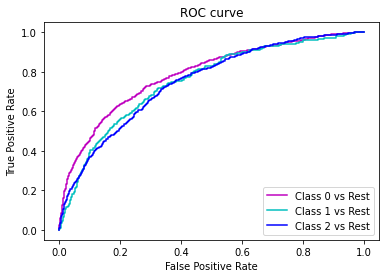

In [28]:
ROC_Curve(y_valid, y_valid_pred)

## <font color='magenta'>Training and Evaluation using CrossEntropyLoss</font>

In [29]:
class NeuralNetwork(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
      
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H2, D_out)
        
    def forward(self, x):
        h1 = self.linear1(x)
        # h1 = self.activation(h1)
        h2 = self.linear2(h1)
        # h2 = self.activation(h2)
        h3 = self.linear3(h2)
        # h3 = self.activation(h3)
        out = self.linear4(h2)
        return out

In [30]:
x_train, y_train, x_valid, y_valid, train_dataset, train_dataloader = Initialize_feauture_Targets(100)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

torch.Size([15976, 200]) torch.Size([15976, 1])
torch.Size([2282, 200]) torch.Size([2282, 1])


In [31]:
#Define layer sizes
D_in = embedding_dimension
H1 = 45
H2 = 20
H3 = 8
D_out = 3

#Define Hyperparameters
learning_rate = 1e-4

#Initialize model, loss, optimizer
Glove_Model = NeuralNetwork(D_in, H1, H2, H3, D_out)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(Glove_Model.parameters(), lr=learning_rate)

In [32]:
#loss_func = nn.CrossEntropyLoss()
def Train_and_Evaluate_Neural_Network_Cross(Glove_Model, train_dataloader, x_valid):
  train_epoch_losses = []
  valid_epoch_losses = []

  for epoch in range(100):
    train_batch_losses = []
    Glove_Model.train()
    for x_train_batch, y_train_batch in train_dataloader:
      y_train_pred = Glove_Model(x_train_batch)
      train_prob = nn.Softmax(dim=1)(y_train_pred)
      y_train_pred_class = torch.argmax(train_prob, dim=1)

      y_train_batch = y_train_batch.view(x_train_batch.shape[0])
      loss = loss_func(y_train_pred, y_train_batch)  
      train_batch_losses.append(loss.item())

      #Delete previously stored gradients
      optimizer.zero_grad()
      #Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()
      #Update model's weights based on the gradients calculated during backprop
      optimizer.step()
      train_epoch_loss = sum(train_batch_losses) / len(train_dataloader)
      
    if (epoch % 9 == 0):
      print(f"Epoch {epoch:3}: Train Loss = {train_epoch_loss:.5f}")
    train_epoch_losses.append(train_epoch_loss)


    Glove_Model.eval()
    optimizer.zero_grad()
    y_valid_pred = Glove_Model(x_valid)
    valid_prob = nn.Softmax(dim=1)(y_valid_pred)
    y_valid_pred_class = torch.argmax(y_valid_pred, dim=1)

    y_valid2 = y_valid.view(y_valid.shape[0])
    loss = loss_func(y_valid_pred, y_valid2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    valid_epoch_losses.append(loss.item())
    if (epoch % 9 == 0):
      print(f"Epoch {epoch:3}: Validation Loss = {loss:.5f}")

  return train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_pred
      

In [33]:
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_pred = Train_and_Evaluate_Neural_Network_MSE(Glove_Model, train_dataloader, x_valid = x_valid)

Epoch   0: Train Loss = 0.26372
Epoch   0: Validation Loss = 0.20176
Epoch   9: Train Loss = 0.16842
Epoch   9: Validation Loss = 0.17087
Epoch  18: Train Loss = 0.16395
Epoch  18: Validation Loss = 0.16833
Epoch  27: Train Loss = 0.16211
Epoch  27: Validation Loss = 0.16610
Epoch  36: Train Loss = 0.16122
Epoch  36: Validation Loss = 0.16592
Epoch  45: Train Loss = 0.16067
Epoch  45: Validation Loss = 0.16549
Epoch  54: Train Loss = 0.16023
Epoch  54: Validation Loss = 0.16503
Epoch  63: Train Loss = 0.16013
Epoch  63: Validation Loss = 0.16497
Epoch  72: Train Loss = 0.16001
Epoch  72: Validation Loss = 0.16466
Epoch  81: Train Loss = 0.15980
Epoch  81: Validation Loss = 0.16468
Epoch  90: Train Loss = 0.15998
Epoch  90: Validation Loss = 0.16470
Epoch  99: Train Loss = 0.15976
Epoch  99: Validation Loss = 0.16506


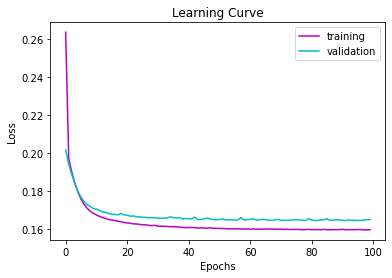

In [34]:
epochs = np.arange(0, 100).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [35]:
calculate_metrics(y_valid, y_valid_pred, y_valid_pred_class)

              precision    recall  f1-score   support

     class 0       0.69      0.72      0.71      1065
     class 1       0.52      0.04      0.07       296
     class 2       0.57      0.70      0.63       921

    accuracy                           0.63      2282
   macro avg       0.59      0.49      0.47      2282
weighted avg       0.62      0.63      0.59      2282

Precision score:	 0.5934847604143378
Recall score:		 0.48854261771979807
F1 score:		 0.46815573833448676


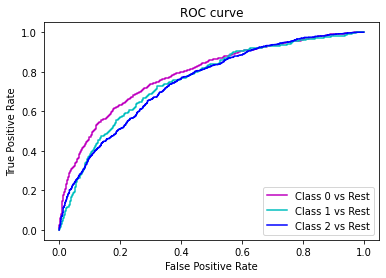

In [36]:
ROC_Curve(y_valid, y_valid_pred)

# <font color='greenyellow'>Neural Network using TF-IDF vectorizer</font>

In [37]:
def TfidfVectorizer_Model(training_df, validation_df, max_features=1000):
  training_size = []
  f1scores_training = []
  f1scores_validation = []

  
  stopword_dict = stopwords.words('english')
  vectorizer = TfidfVectorizer(stop_words = stopword_dict, max_features = max_features, max_df=5000)
  training_data = vectorizer.fit_transform(training_df['cleaned tweet'])

  voc_list = (vectorizer.get_feature_names_out())  #list of the features
  training_data = training_data.toarray()

  validation_data = vectorizer.transform(validation_df['tweet'].values)
  validation_data = validation_data.toarray()
    
  return training_data, validation_data


In [38]:
training_numeric_array, validation_numeric_array = TfidfVectorizer_Model(training_df, validation_df)

## <font color='magenta'>Training and Evaluation using MSELoss</font>

In [39]:
class NeuralNetwork(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
      
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H2, D_out)
        
    def forward(self, x):
        h1 = self.linear1(x)
        h1 = self.activation(h1)
        h2 = self.linear2(h1)
        h2 = self.activation(h2)
        h3 = self.linear3(h2)
        h3 = self.activation(h3)
        out = self.linear4(h2)
        return out

In [40]:
x_train, y_train, x_valid, y_valid, train_dataset, train_dataloader = Initialize_feauture_Targets(100)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

torch.Size([15976, 1000]) torch.Size([15976, 1])
torch.Size([2282, 1000]) torch.Size([2282, 1])


In [41]:
#Define layer sizes
D_in = 1000
H1 = 45
H2 = 20
H3 = 8
D_out = 3

#Define Hyperparameters
learning_rate = 1e-4

#Initialize model, loss, optimizer
Glove_Model = NeuralNetwork(D_in, H1, H2, H3, D_out)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(Glove_Model.parameters(), lr=learning_rate)

In [42]:
#loss_func = MSELoss()
def Train_and_Evaluate_Neural_Network_MSE(Glove_Model, train_dataloader, x_valid):
  train_epoch_losses = []
  valid_epoch_losses = []

  for epoch in range(100):
    train_batch_losses = []
    Glove_Model.train()
    for x_train_batch, y_train_batch in train_dataloader:
      y_train_pred = Glove_Model(x_train_batch)
      train_prob = nn.Softmax(dim=1)(y_train_pred)
      y_train_pred_class = torch.argmax(train_prob, dim=1)
      
      y_train_batch_one_hot = torch.nn.functional.one_hot(y_train_batch)
      y_train_batch_one_hot = y_train_batch_one_hot.reshape(y_train_pred.shape[0], y_train_pred.shape[1])
      loss = loss_func(y_train_pred.float(), y_train_batch_one_hot.float())
      train_batch_losses.append(loss.item())

      #Delete previously stored gradients
      optimizer.zero_grad()
      #Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()
      #Update model's weights based on the gradients calculated during backprop
      optimizer.step()
      train_epoch_loss = sum(train_batch_losses) / len(train_dataloader)
      
    if (epoch % 9 == 0):
      print(f"Epoch {epoch:3}: Train Loss = {train_epoch_loss:.5f}")
    train_epoch_losses.append(train_epoch_loss)


    Glove_Model.eval()
    # optimizer.zero_grad()
    y_valid_pred = Glove_Model(x_valid)
    valid_prob = nn.Softmax(dim=1)(y_valid_pred)
    y_valid_pred_class = torch.argmax(y_valid_pred, dim=1)

    y_valid_one_hot = torch.nn.functional.one_hot(y_valid)
    y_valid_one_hot = y_valid_one_hot.reshape(y_valid_pred.shape[0], y_valid_pred.shape[1])
    loss = loss_func(y_valid_pred.float(), y_valid_one_hot.float())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    valid_epoch_losses.append(loss.item())
    if (epoch % 9 == 0):
      print(f"Epoch {epoch:3}: Validation Loss = {loss:.5f}")

  return train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_pred
      

In [43]:
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_pred = Train_and_Evaluate_Neural_Network_MSE(Glove_Model, train_dataloader, x_valid = x_valid)

Epoch   0: Train Loss = 0.40148
Epoch   0: Validation Loss = 0.36632
Epoch   9: Train Loss = 0.16260
Epoch   9: Validation Loss = 0.16120
Epoch  18: Train Loss = 0.12710
Epoch  18: Validation Loss = 0.13627
Epoch  27: Train Loss = 0.11884
Epoch  27: Validation Loss = 0.13248
Epoch  36: Train Loss = 0.11390
Epoch  36: Validation Loss = 0.13150
Epoch  45: Train Loss = 0.10968
Epoch  45: Validation Loss = 0.13121
Epoch  54: Train Loss = 0.10550
Epoch  54: Validation Loss = 0.13114
Epoch  63: Train Loss = 0.10107
Epoch  63: Validation Loss = 0.13109
Epoch  72: Train Loss = 0.09649
Epoch  72: Validation Loss = 0.13135
Epoch  81: Train Loss = 0.09161
Epoch  81: Validation Loss = 0.13179
Epoch  90: Train Loss = 0.08645
Epoch  90: Validation Loss = 0.13278
Epoch  99: Train Loss = 0.08121
Epoch  99: Validation Loss = 0.13382


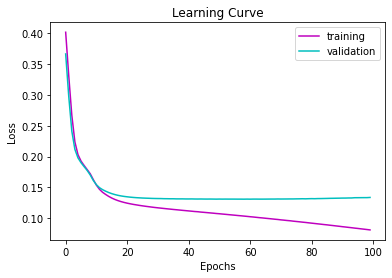

In [44]:
epochs = np.arange(0, 100).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [45]:
calculate_metrics(y_valid, y_valid_pred, y_valid_pred_class)

              precision    recall  f1-score   support

     class 0       0.78      0.77      0.78      1065
     class 1       0.59      0.47      0.52       296
     class 2       0.68      0.74      0.71       921

    accuracy                           0.72      2282
   macro avg       0.68      0.66      0.67      2282
weighted avg       0.72      0.72      0.71      2282

Precision score:	 0.6839307302590872
Recall score:		 0.6573929368190047
F1 score:		 0.6677691299126929


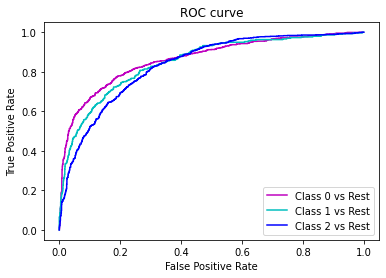

In [46]:
ROC_Curve(y_valid, y_valid_pred)

## <font color='magenta'>Training and Evaluation using CrossEntropyLoss</font>

In [47]:
class NeuralNetwork(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
      
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H2, D_out)
        
    def forward(self, x):
        h1 = self.linear1(x)
        h1 = self.activation(h1)
        h2 = self.linear2(h1)
        h2 = self.activation(h2)
        h3 = self.linear3(h2)
        h3 = self.activation(h3)
        out = self.linear4(h2)
        return out

In [48]:
x_train, y_train, x_valid, y_valid, train_dataset, train_dataloader = Initialize_feauture_Targets(200)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

torch.Size([15976, 1000]) torch.Size([15976, 1])
torch.Size([2282, 1000]) torch.Size([2282, 1])


In [49]:
#Define layer sizes
D_in = 1000
H1 = 35
H2 = 15
H3 = 8
D_out = 3

#Define Hyperparameters
learning_rate = 1e-4

#Initialize model, loss, optimizer
Glove_Model = NeuralNetwork(D_in, H1, H2, H3, D_out)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Glove_Model.parameters(), lr=learning_rate)

In [50]:
#loss_func = nn.CrossEntropyLoss()
def Train_and_Evaluate_Neural_Network_Cross(Glove_Model, train_dataloader, x_valid):
  train_epoch_losses = []
  valid_epoch_losses = []

  for epoch in range(100):
    train_batch_losses = []
    Glove_Model.train()
    for x_train_batch, y_train_batch in train_dataloader:
      y_train_pred = Glove_Model(x_train_batch)
      train_prob = nn.Softmax(dim=1)(y_train_pred)
      y_train_pred_class = torch.argmax(train_prob, dim=1)

      y_train_batch = y_train_batch.view(x_train_batch.shape[0])
      loss = loss_func(y_train_pred, y_train_batch)  
      train_batch_losses.append(loss.item())

      #Delete previously stored gradients
      optimizer.zero_grad()
      #Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()
      #Update model's weights based on the gradients calculated during backprop
      optimizer.step()
      train_epoch_loss = sum(train_batch_losses) / len(train_dataloader)

    if (epoch % 9 == 0):
      print(f"Epoch {epoch:3}: Train Loss = {train_epoch_loss:.5f}")
    train_epoch_losses.append(train_epoch_loss)


    Glove_Model.eval()
    optimizer.zero_grad()
    y_valid_pred = Glove_Model(x_valid)
    valid_prob = nn.Softmax(dim=1)(y_valid_pred)
    y_valid_pred_class = torch.argmax(y_valid_pred, dim=1)

    y_valid2 = y_valid.view(y_valid.shape[0])
    loss = loss_func(y_valid_pred, y_valid2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    valid_epoch_losses.append(loss.item())
    if (epoch % 9 == 0):
      print(f"Epoch {epoch:3}: Validation Loss = {loss:.5f}")

  return train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_pred
      

In [51]:
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_pred = Train_and_Evaluate_Neural_Network_Cross(Glove_Model, train_dataloader, x_valid = x_valid)

Epoch   0: Train Loss = 1.09910
Epoch   0: Validation Loss = 1.09570
Epoch   9: Train Loss = 0.87433
Epoch   9: Validation Loss = 0.87054
Epoch  18: Train Loss = 0.72141
Epoch  18: Validation Loss = 0.75415
Epoch  27: Train Loss = 0.69042
Epoch  27: Validation Loss = 0.73461
Epoch  36: Train Loss = 0.66691
Epoch  36: Validation Loss = 0.71878
Epoch  45: Train Loss = 0.64037
Epoch  45: Validation Loss = 0.69890
Epoch  54: Train Loss = 0.61857
Epoch  54: Validation Loss = 0.68452
Epoch  63: Train Loss = 0.60554
Epoch  63: Validation Loss = 0.67802
Epoch  72: Train Loss = 0.59746
Epoch  72: Validation Loss = 0.67552
Epoch  81: Train Loss = 0.59197
Epoch  81: Validation Loss = 0.67490
Epoch  90: Train Loss = 0.58747
Epoch  90: Validation Loss = 0.67481
Epoch  99: Train Loss = 0.58364
Epoch  99: Validation Loss = 0.67519


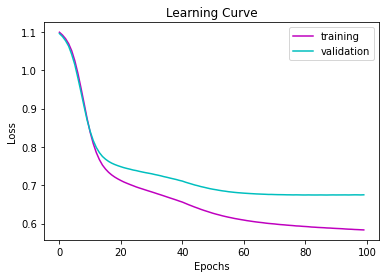

In [52]:
epochs = np.arange(0, 100).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [53]:
calculate_metrics(y_valid, y_valid_pred, y_valid_pred_class)

              precision    recall  f1-score   support

     class 0       0.77      0.76      0.77      1065
     class 1       0.59      0.42      0.49       296
     class 2       0.67      0.74      0.71       921

    accuracy                           0.71      2282
   macro avg       0.68      0.64      0.66      2282
weighted avg       0.71      0.71      0.71      2282

Precision score:	 0.6772865713273203
Recall score:		 0.6427339265218331
F1 score:		 0.655011151324411


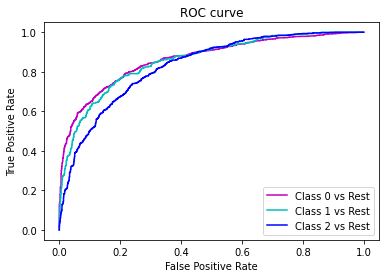

In [54]:
ROC_Curve(y_valid, y_valid_pred)